# Домашнее задание по теме  
## «Регрессия SVM»

Использую набор данных из прошлых заданий.  Столбец “Premium Amount” является целевой переменной

Импорт библиотек

In [20]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from eda_tools import get_all_outliers, get_boxplot, get_eda, get_cat_eda, get_correlation_target 


In [21]:
# Загрузка файла с данными из архива
archive_path = 'input_data/train.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('train.csv') as file:
        df = pd.read_csv(file)

### Подготовка исходных данных

In [22]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [23]:
# Удаляю все пропуски т.к. объем данных большой для SVR
df = df.dropna()
# Удаляю 97% от остатка по той же причине (1257 минут я уже ждал)
df = df.drop(df.sample(frac=0.97).index)

In [24]:
df.info(memory_usage=True) # Вывод столбцов и их типов
df.head() # Вывод "шапки"

<class 'pandas.core.frame.DataFrame'>
Index: 11520 entries, 115 to 1199986
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11520 non-null  int64  
 1   age                   11520 non-null  float64
 2   gender                11520 non-null  object 
 3   annual_income         11520 non-null  float64
 4   marital_status        11520 non-null  object 
 5   number_of_dependents  11520 non-null  float64
 6   education_level       11520 non-null  object 
 7   occupation            11520 non-null  object 
 8   health_score          11520 non-null  float64
 9   location              11520 non-null  object 
 10  policy_type           11520 non-null  object 
 11  previous_claims       11520 non-null  float64
 12  vehicle_age           11520 non-null  float64
 13  credit_score          11520 non-null  float64
 14  insurance_duration    11520 non-null  float64
 15  policy_start_date   

,id,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,...,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount
115,115,39.0,Female,36373.0,Divorced,2.0,Master's,Employed,13.518571,Rural,...,1.0,0.0,748.0,4.0,2021-04-10 15:21:39.148733,Average,No,Rarely,Apartment,454.0
443,443,22.0,Female,25148.0,Single,3.0,Master's,Self-Employed,13.743005,Rural,...,0.0,12.0,602.0,5.0,2022-02-24 15:21:39.120168,Average,No,Daily,House,845.0
501,501,28.0,Male,54745.0,Divorced,4.0,PhD,Employed,7.785723,Urban,...,2.0,4.0,326.0,5.0,2020-01-24 15:21:39.211806,Poor,No,Weekly,House,1003.0
802,802,21.0,Female,18282.0,Single,2.0,High School,Employed,45.284423,Rural,...,3.0,5.0,644.0,9.0,2020-03-25 15:21:39.290098,Average,No,Rarely,House,717.0
844,844,24.0,Male,5857.0,Divorced,3.0,Master's,Unemployed,21.972250,Rural,...,0.0,17.0,418.0,4.0,2021-04-03 15:21:39.116179,Good,No,Weekly,House,2895.0


In [25]:
df.describe(include='all')

,id,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,...,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount
count,1.152000e+04,11520.000000,11520,11520.000000,11520,11520.000000,11520,11520,11520.000000,11520,...,11520.000000,11520.000000,11520.000000,11520.000000,11520,11520,11520,11520,11520,11520.000000
unique,NaN,NaN,2,NaN,3,NaN,4,3,NaN,3,...,NaN,NaN,NaN,NaN,10625,3,2,4,3,NaN
top,NaN,NaN,Male,NaN,Single,NaN,Master's,Employed,NaN,Rural,...,NaN,NaN,NaN,NaN,2021-09-12 15:21:39.134960,Average,Yes,Monthly,House,NaN
freq,NaN,NaN,5769,NaN,3914,NaN,3047,3855,NaN,3914,...,NaN,NaN,NaN,NaN,5,3864,5787,2942,3890,NaN
mean,6.013546e+05,41.163628,NaN,32888.112847,NaN,2.018663,NaN,NaN,25.373447,NaN,...,0.994097,9.495747,594.814844,5.017448,NaN,NaN,NaN,NaN,NaN,1116.708333
std,3.453972e+05,13.490688,NaN,32031.520048,NaN,1.413323,NaN,NaN,12.224141,NaN,...,0.978704,5.786623,149.711575,2.591188,NaN,NaN,NaN,NaN,NaN,870.846596
min,1.150000e+02,18.000000,NaN,11.000000,NaN,0.000000,NaN,NaN,2.260093,NaN,...,0.000000,0.000000,300.000000,1.000000,NaN,NaN,NaN,NaN,NaN,20.000000
25%,3.042502e+05,30.000000,NaN,8072.750000,NaN,1.000000,NaN,NaN,15.710888,NaN,...,0.000000,4.000000,472.000000,3.000000,NaN,NaN,NaN,NaN,NaN,519.000000
50%,6.008510e+05,41.000000,NaN,24165.000000,NaN,2.000000,NaN,NaN,24.084718,NaN,...,1.000000,9.000000,596.000000,5.000000,NaN,NaN,NaN,NaN,NaN,884.000000
75%,8.988598e+05,53.000000,NaN,44726.750000,NaN,3.000000,NaN,NaN,34.122671,NaN,...,2.000000,15.000000,722.000000,7.000000,NaN,NaN,NaN,NaN,NaN,1517.000000


### Числовые переменные

In [26]:
eda_df = get_eda(df)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
age,0,0.0,64.00000,18.000000,41.163628,41.000000,1.819987e+02,22.00000,60.000000,30.000000,53.000000,0,float64,47,0,0,0
annual_income,0,0.0,149920.00000,11.000000,32888.112847,24165.000000,1.026018e+09,2639.00000,80987.600000,8072.750000,44726.750000,0,float64,8014,0,0,666
number_of_dependents,0,0.0,4.00000,0.000000,2.018663,2.000000,1.997481e+00,0.00000,4.000000,1.000000,3.000000,0,float64,5,2273,0,0
health_score,0,0.0,55.93428,2.260093,25.373447,24.084718,1.494296e+02,9.75225,42.940198,15.710888,34.122671,11520,float64,11074,0,0,0
previous_claims,0,0.0,7.00000,0.000000,0.994097,1.000000,9.578608e-01,0.00000,2.000000,0.000000,2.000000,0,float64,8,4256,0,5
vehicle_age,0,0.0,19.00000,0.000000,9.495747,9.000000,3.348501e+01,1.00000,18.000000,4.000000,15.000000,0,float64,20,608,0,0
credit_score,0,0.0,849.00000,300.000000,594.814844,596.000000,2.241356e+04,384.00000,793.000000,472.000000,722.000000,0,float64,550,0,0,0
insurance_duration,0,0.0,9.00000,1.000000,5.017448,5.000000,6.714254e+00,1.00000,9.000000,3.000000,7.000000,0,float64,9,0,0,0
premium_amount,0,0.0,4985.00000,20.000000,1116.708333,884.000000,7.583738e+05,168.00000,2411.100000,519.000000,1517.000000,0,float64,2730,0,0,498


Категориальные переменные

In [27]:
get_cat_eda(df)

,Тип данных,nunique,mode,Количество пропусков,Доля пропусков (%),Топ-1 категория,Доля топ-1 категории (%),Количество редких категорий (<1%)
Параметр,,,,,,,,
gender,object,2,Male,0,0.0,Male,50.078125,0
marital_status,object,3,Single,0,0.0,Single,33.975694,0
education_level,object,4,Master's,0,0.0,Master's,26.449653,0
occupation,object,3,Employed,0,0.0,Employed,33.463542,0
location,object,3,Rural,0,0.0,Rural,33.975694,0
policy_type,object,3,Comprehensive,0,0.0,Comprehensive,33.663194,0
policy_start_date,object,10625,2021-09-12 15:21:39.134960,0,0.0,2021-09-12 15:21:39.134960,0.043403,10625
customer_feedback,object,3,Average,0,0.0,Average,33.541667,0
smoking_status,object,2,Yes,0,0.0,Yes,50.234375,0


In [28]:
# Удаление ненужных столбцов
df = df.drop(columns=['customer_feedback', 'policy_start_date', 'id'])

In [29]:
# Кодирование категориальных переменных
# One-Hot Encoding 
columns_to_encode = ['gender', 'smoking_status', 'location',  'gender']  
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True, dtype=int)

# Label Encoding
label_encoder = LabelEncoder()
df['education_level'] = label_encoder.fit_transform(df['education_level'])
df['occupation'] = label_encoder.fit_transform(df['occupation'])
df['property_type'] = label_encoder.fit_transform(df['property_type'])
df['marital_status'] = label_encoder.fit_transform(df['marital_status'])
df['policy_type'] = label_encoder.fit_transform(df['policy_type'])
df['education_level'] = label_encoder.fit_transform(df['education_level'])
df['exercise_frequency'] = label_encoder.fit_transform(df['exercise_frequency'])

df = df.drop(columns=['education_level', 'occupation', 'property_type','marital_status','policy_type', 'education_level', 'exercise_frequency'])

In [30]:
get_eda(df)

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
age,0,0.0,64.00000,18.000000,41.163628,41.000000,1.819987e+02,22.00000,60.000000,30.000000,53.000000,0,float64,47,0,0,0
annual_income,0,0.0,149920.00000,11.000000,32888.112847,24165.000000,1.026018e+09,2639.00000,80987.600000,8072.750000,44726.750000,0,float64,8014,0,0,666
number_of_dependents,0,0.0,4.00000,0.000000,2.018663,2.000000,1.997481e+00,0.00000,4.000000,1.000000,3.000000,0,float64,5,2273,0,0
health_score,0,0.0,55.93428,2.260093,25.373447,24.084718,1.494296e+02,9.75225,42.940198,15.710888,34.122671,11520,float64,11074,0,0,0
previous_claims,0,0.0,7.00000,0.000000,0.994097,1.000000,9.578608e-01,0.00000,2.000000,0.000000,2.000000,0,float64,8,4256,0,5
vehicle_age,0,0.0,19.00000,0.000000,9.495747,9.000000,3.348501e+01,1.00000,18.000000,4.000000,15.000000,0,float64,20,608,0,0
credit_score,0,0.0,849.00000,300.000000,594.814844,596.000000,2.241356e+04,384.00000,793.000000,472.000000,722.000000,0,float64,550,0,0,0
insurance_duration,0,0.0,9.00000,1.000000,5.017448,5.000000,6.714254e+00,1.00000,9.000000,3.000000,7.000000,0,float64,9,0,0,0
premium_amount,0,0.0,4985.00000,20.000000,1116.708333,884.000000,7.583738e+05,168.00000,2411.100000,519.000000,1517.000000,0,float64,2730,0,0,498


Работа с выбросами

In [31]:
df_outliers = get_all_outliers(df[['annual_income', 'previous_claims', 'premium_amount']])
df_outliers

,Количество выбросов слева,Количество нормальных данных,Количество выбросов справа
annual_income,0,10854,666
previous_claims,0,11515,5
premium_amount,0,11022,498


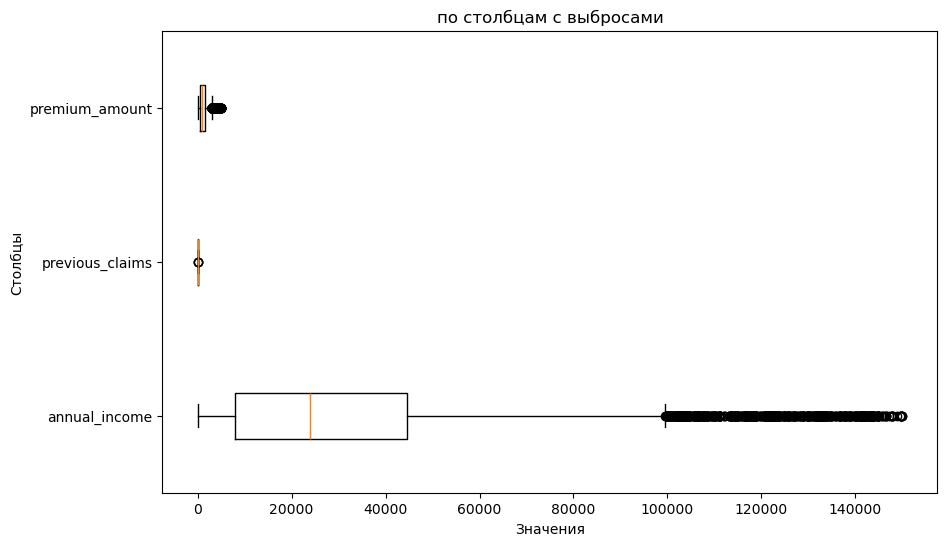

In [13]:
get_boxplot(df[['annual_income', 'previous_claims', 'premium_amount']], 'по столбцам с выбросами').show()

In [32]:
# Корректировка выбросов по верхней границе
def get_iqr_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Вычисление границы для каждого столбца
l_lower, l_upper = get_iqr_bounds(df['annual_income'])
df['annual_income'] = df['annual_income'].clip(upper=l_upper)

l_lower, l_upper = get_iqr_bounds(df['premium_amount'])
df['premium_amount'] = df['premium_amount'].clip(upper=l_upper)

l_lower, l_upper = get_iqr_bounds(df['previous_claims'])
df['previous_claims'] = df['previous_claims'].clip(upper=l_upper)

Выбор критериев для обучения

In [33]:
# Выбор лучших признаков
X = df.drop(columns=['premium_amount'])  # Все признаки
y = df['premium_amount']  # Целевая переменная

k = 4  # Количество признаков в отборе
selector = SelectKBest(score_func=f_regression, k=k)

X_new = selector.fit_transform(X, y)

# Индексы выбранных признаков
selected_indices = selector.get_support(indices=True)

# Названия выбранных признаков
selected_features = X.columns[selected_indices]

print("Выбранные признаки:")
print(selected_features)

Выбранные признаки:
Index(['health_score', 'previous_claims', 'credit_score', 'gender_Male'], dtype='object')


In [34]:
# Выбранные поля для обучения:
df = df[['age', 'health_score', 'previous_claims', 'credit_score','premium_amount']]

Трансормация данных данных

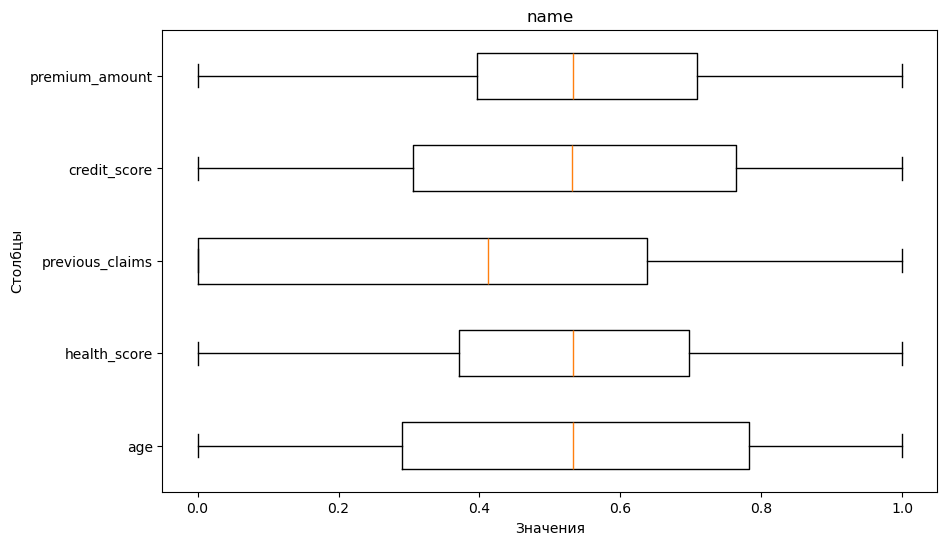

In [35]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True) 

# Применение трансформации к числовым признакам
# Выбираем только числовые столбцы для масштабирования
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = power_transformer.fit_transform(df[numeric_columns])

# Масштабирование с помощью MinMaxScaler
minmax_scaler = MinMaxScaler()
scaled_data_minmax = minmax_scaler.fit_transform(df)
df_minmax_scaled = pd.DataFrame(scaled_data_minmax, columns=df.columns)
df = df_minmax_scaled
get_boxplot(df,'name').show()

In [37]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df[['age', 'health_score', 'previous_claims', 'credit_score' ]]    
y = df['premium_amount']  # Целевая переменная
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Обучение модели KNN регрессии
knn_model = KNeighborsRegressor(n_neighbors=100) 
knn_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_knn = knn_model.predict(X_test)

# Оценка производительности KNN
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print(f"KNN - Mean Squared Error: {mse_knn}, R2 Score: {r2_knn}, MAE: {mae_knn}")

KNN - Mean Squared Error: 0.06040969458228044, R2 Score: 0.0059596141150648485, MAE: 0.19656468152478862


In [39]:
# Обучение модели SVR
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_svr = svr_model.predict(X_test)

# Оценка производительности SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print(f"SVR - Mean Squared Error: {mse_svr}, R2 Score: {r2_svr}, MAE: {mae_svr}")


SVR - Mean Squared Error: 0.06068730085709154, R2 Score: 0.0013916080947488085, MAE: 0.1966845739993284


### Сравнение:
1. MSE -  KNN немного лучше, так как его MSE меньше. Разница минимальнв.
2. R2 Score -  KNN немного лучше, так как его R2 Score выше. Разница минимальна.
3. MAE - SVR немного лучше, так как его MAE меньше. Разница минимальна.
### Вывод:
- Обе модели работают плохо.
- Значения R2 Score близки к нулю, что указывает на то, что ни одна из моделей не объясняет дисперсию целевой переменной.

In [40]:
pipeline = Pipeline([
    ('svr', SVR())  
])

In [ ]:
# Определение сетки гиперпараметров
# Делаю минимум вариаций
param_grid = {
    'svr__kernel': ['rbf', 'poly'],  # Выбор ядра
    'svr__C': [0.1, 1, 10],  # Параметр регуляризации
    'svr__gamma': [0.01, 0.1, 1],  # Параметр ядра RBF и poly
    'svr__degree': [2, 3]  # Степень для ядра poly
}

In [46]:
# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,  # Пайплайн
    param_grid=param_grid,  # Сетка гиперпараметров
    scoring='neg_mean_squared_error',  # Метрика для оптимизации
    cv=5,  # Количество фолдов для кросс-валидации
    verbose=1,  # Вывод информации о процессе
    n_jobs=-1  # Использование всех доступных ядер процессора
)

In [47]:
# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('svr', SVR())]), n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10], 'svr__degree': [2, 3],
                         'svr__gamma': [0.01, 0.1, 1],
                         'svr__kernel': ['rbf', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [48]:

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'svr__C': 1, 'svr__degree': 2, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}


In [49]:
# Оценка производительности на тестовых данных с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Лучшая модель SVR - MSE: {mse}, R2: {r2}, MAE: {mae}")

Лучшая модель SVR - MSE: 0.06024167460001487, R2: 0.008724379756780865, MAE: 0.19605195925180519
